### Imports & plotting style

In [1]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import ceil
from skfda.representation.grid import FDataGrid
from skfda.representation.basis import FourierBasis
from skfda.ml.regression import LinearRegression
from typing import Tuple, List, Dict
import calendar

plt.style.use('seaborn-v0_8-colorblind')

### Monthly daily-series helpers & 4-panel plot

In [2]:
def _monthly_daily_series(df, ts_col, value_col, start=None, end=None, agg="mean"):
    """
    Build a long DataFrame: one row per (year-month, day) with a daily statistic.
    Returns columns: ym (Period[M]), day_idx (0..30), value.
    """
    d = df.copy()
    d[ts_col] = pd.to_datetime(d[ts_col])
    if start is not None:
        d = d[d[ts_col] >= pd.to_datetime(start)]
    if end is not None:
        d = d[d[ts_col] < pd.to_datetime(end)]

    d["ym"] = d[ts_col].dt.to_period("M")
    d["day_date"] = d[ts_col].dt.floor("D")

    gb = d.groupby(["ym", "day_date"], observed=False)[value_col]
    if agg == "median":
        daily = gb.median()
    else:
        daily = gb.mean()
    daily = daily.reset_index().rename(columns={value_col: "value"})
    daily["day_idx"] = daily["day_date"].dt.day - 1  # 0..30
    return daily[["ym", "day_idx", "value"]]


def plot_monthly_curves_fourpanel(
    df: pd.DataFrame,
    ts_col: str = "datetime",
    y_col: str = "day_ahead_price_eur",
    x_cols: list[str] = ("co2_eur/ton", "natural_gas_eur/mwh", "coal_eur/ton"),
    labels: list[str] = ("Day-ahead price", "CO₂", "Gas", "Coal"),
    *,
    start: str | None = None,     # e.g. "2023-01-01"
    end: str | None = None,       # e.g. "2025-01-01"
    target_color: str = "tab:blue",
    pred_color: str = "tab:red",
    alpha: float = 0.22,
    lw: float = 1.2,
    figsize=(18, 4.2),
    agg: str = "mean",            # daily aggregator: "mean" or "median"
):
    """
    Make a 1×4 panel:
      [0] day-ahead price (blue), one curve per month (year×month)
      [1] CO₂ (red)   [2] Gas (red)   [3] Coal (red)
    X-axis = day index 0..30 ⇒ shorter months end earlier.
    """
    # Build long monthly-daily series for each variable
    y_daily = _monthly_daily_series(df, ts_col, y_col, start, end, agg)
    x_daily = [_monthly_daily_series(df, ts_col, col, start, end, agg) for col in x_cols]

    # Plot
    fig, axs = plt.subplots(1, 4, figsize=figsize, constrained_layout=True)

    def _style_axis(ax, title, color):
        ax.set_xlim(0, 30)
        ax.set_xticks(np.arange(0, 31, 2))
        ax.set_xlabel("day within month (0–30)")
        ax.set_title(title)
        ax.grid(True, alpha=.25)
        # Y label only on the first subplot to avoid clutter
        if ax is axs[0]:
            ax.set_ylabel("€/MWh" if "price" in y_col else "")

    # [0] target in blue
    for _, sub in y_daily.groupby("ym", sort=True):
        sub = sub.sort_values("day_idx")
        axs[0].plot(sub["day_idx"], sub["value"], color=target_color, alpha=alpha, lw=lw)
    _style_axis(axs[0], labels[0] + " — monthly curves (daily " + agg + ")", target_color)

    # [1–3] predictors in red
    for j in range(3):
        for _, sub in x_daily[j].groupby("ym", sort=True):
            sub = sub.sort_values("day_idx")
            axs[j+1].plot(sub["day_idx"], sub["value"], color=pred_color, alpha=alpha, lw=lw)
        _style_axis(axs[j+1], labels[j+1] + " — monthly curves (daily " + agg + ")", pred_color)

    return fig


### Small Utilities for curve evaluation

In [3]:
def _eval_fd(fd, t: np.ndarray) -> np.ndarray:
    """Evaluate scikit-fda object using callable form (no deprecation warnings)."""
    return np.asarray(fd(t)).squeeze()


def _brief(curve: np.ndarray, t_int: np.ndarray) -> Dict[str, float]:
    """Tiny summary for a 1D curve on integer grid t_int."""
    tmax, tmin = int(t_int[np.argmax(curve)]), int(t_int[np.argmin(curve)])
    return {
        "t_max": tmax, "v_max": float(curve[tmax]),
        "t_min": tmin, "v_min": float(curve[tmin]),
        "mean": float(np.mean(curve)),
    }

### Calendar domain construction & aggregation

In [4]:
def choose_domain_and_samples(
    df: pd.DataFrame,
    ts_col: str,
    calendar: str,
) -> Tuple[pd.DataFrame, int, str]:
    """
    Create 'sample' (row id) and 't' (domain point) columns based on calendar mode.

    Returns:
      d       : dataframe copy with 'sample' and 't'
      T       : number of domain points (0..T-1)
      x_label : xlabel string for plots
    """
    assert calendar in {"hour", "week", "month", "quarter", "year"}
    ts = pd.to_datetime(df[ts_col])
    d = df.copy()

    if calendar == "hour":
        d["sample"] = ts.dt.floor("D")          # one curve per day
        d["t"] = ts.dt.hour                     # 0..23
        T, x_label = 24, "hour-of-day (0–23)"

    elif calendar == "week":
        wk = ts.dt.isocalendar().week.astype(int) - 1
        mask = wk <= 51                         # drop ISO week 53 to keep 0..51
        d = d.loc[mask].copy()
        d["sample"] = ts.loc[mask].dt.year      # one curve per year
        d["t"] = wk[mask]                       # 0..51
        T, x_label = 52, "week-of-year (0–51)"

    elif calendar == "month":
        d["sample"] = ts.dt.year                 # one curve per year
        d["t"] = ts.dt.month - 1                 # 0..11
        T, x_label = 12, "month-of-year (0–11)"

    elif calendar == "quarter":
        d["sample"] = ts.dt.year                 # one curve per year
        d["t"] = ts.dt.quarter - 1               # 0..3
        T, x_label = 4, "quarter-of-year (0–3)"

    else:  # "year" — domain is year index, replicates are months
        years_sorted = np.sort(ts.dt.year.unique())
        year_index = {y: i for i, y in enumerate(years_sorted)}
        d["sample"] = ts.dt.month - 1            # 0..11 replicates (months)
        d["t"] = ts.dt.year.map(year_index)      # 0..N_years-1 domain
        T = len(years_sorted)
        x_label = f"year index (0–{T-1})"

    return d, T, x_label

def aggregate_sample_domain(
    d: pd.DataFrame,
    y_col: str,
    x_cols: List[str],
    T: int,
) -> Tuple[pd.DataFrame, List[pd.DataFrame]]:
    """
    Average raw rows within each (sample, t) → matrices with rows=samples, cols=t.
    Drops samples with any missing columns (strict complete-case by domain).
    """
    def agg(col: str) -> pd.DataFrame:
        return d.groupby(["sample", "t"], observed=False)[col].mean().unstack("t")

    Yw = agg(y_col)
    Xw_list = [agg(c) for c in x_cols]

    # enforce full 0..T-1 columns
    full_t = list(range(T))
    Yw = Yw.reindex(columns=full_t)
    Xw_list = [Xw.reindex(columns=full_t) for Xw in Xw_list]

    # drop incomplete samples (rows with any NaN across domain)
    good = Yw.dropna(axis=0, how="any").index
    for Xw in Xw_list:
        good = good.intersection(Xw.dropna(axis=0, how="any").index)

    Yw = Yw.loc[good]
    Xw_list = [Xw.loc[good] for Xw in Xw_list]
    return Yw, Xw_list

def center_predictor_curves(Xw_list: List[pd.DataFrame]) -> List[pd.DataFrame]:
    """Center each predictor matrix by its column means so α(t) is baseline at mean profiles."""
    return [Xw - Xw.mean(axis=0) for Xw in Xw_list]


### Fourier basis conversion & concurrent regression

In [5]:
def to_basis(
    Yw: pd.DataFrame,
    Xw_list: List[pd.DataFrame],
    T: int,
    n_basis: int,
) -> Tuple[object, List[object], FourierBasis, FourierBasis]:
    """
    Wrap matrices into FDataGrid and convert to FDataBasis with a Fourier basis on [0, T].
    Returns Y_b, X_b_list, basis_x, basis_y.
    """
    grid = np.arange(T, dtype=float)
    Y_g = FDataGrid(Yw.values, grid_points=grid)
    X_g_list = [FDataGrid(Xw.values, grid_points=grid) for Xw in Xw_list]

    basis_y = FourierBasis(domain_range=(0.0, float(T)), n_basis=n_basis)
    basis_x = FourierBasis(domain_range=(0.0, float(T)), n_basis=n_basis)

    Y_b = Y_g.to_basis(basis_y)
    X_b_list = [Xg.to_basis(basis_x) for Xg in X_g_list]
    return Y_b, X_b_list, basis_x, basis_y
    
def fit_concurrent(
    Y_b,
    X_b_list: List[object],
    basis_x: FourierBasis,
) -> LinearRegression:
    """Fit scikit-fda concurrent linear regression with functional covariates."""
    p = len(X_b_list)
    model = LinearRegression(
        coef_basis=[basis_x] * p,
        fit_intercept=True
    ).fit(X_b_list, Y_b)
    return model

def evaluate_model(
    model: LinearRegression,
    T: int,
) -> Tuple[np.ndarray, np.ndarray, List[np.ndarray], np.ndarray, List[np.ndarray]]:
    """
    Returns:
      t_int, alpha, betas_j, t_fine, betas_fine_j (alpha_f is first element of betas? No—return separately)
    """
    t_int = np.arange(T)
    t_fine = np.linspace(0, T, max(10*T + 1, 41))

    alpha = _eval_fd(model.intercept_, t_int)
    alpha_f = _eval_fd(model.intercept_, t_fine)
    betas_j = []
    betas_fine_j = []
    for j in range(len(model.coef_)):
        bj = _eval_fd(model.coef_[j], t_int)
        bjf = _eval_fd(model.coef_[j], t_fine)
        betas_j.append(bj)
        betas_fine_j.append(bjf)

    return t_int, alpha, betas_j, t_fine, alpha_f, betas_fine_j


### Tidy Outputs

In [6]:
def make_betas_df(
    t_int: np.ndarray,
    alpha: np.ndarray,
    betas_j: List[np.ndarray],
    labels: List[str],
) -> pd.DataFrame:
    """Build a tidy DataFrame with alpha and each beta curve."""
    out = pd.DataFrame({"t": t_int, "alpha": alpha})
    for lbl, b in zip(labels, betas_j):
        out[f"beta_{lbl}"] = b
    return out

def make_brief(
    t_int: np.ndarray,
    alpha: np.ndarray,
    betas_j: List[np.ndarray],
    labels: List[str],
) -> Dict[str, Dict[str, float]]:
    """Make tiny summaries for alpha and every beta."""
    brief = {"alpha": _brief(alpha, t_int)}
    for lbl, b in zip(labels, betas_j):
        brief[f"beta_{lbl}"] = _brief(b, t_int)
    return brief


### Plot α(t) and b_j(t) panels

In [7]:
def plot_alpha_and_betas(
    t_int: np.ndarray,
    alpha: np.ndarray,
    betas_j: List[np.ndarray],
    t_fine: np.ndarray,
    alpha_f: np.ndarray,
    betas_fine_j: List[np.ndarray],
    labels: List[str],
    x_label: str,
    save_path: str | None = None,
):
    """Make panel plots. y=0 grey line only on β-panels. Show all integer ticks 0..T."""
    T = int(t_int.max()) + 1
    n_panels = 1 + len(betas_j)
    ncols = 2
    nrows = ceil(n_panels / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 3.3 * nrows), constrained_layout=True)
    axes = np.atleast_1d(axes).ravel()

    # α(t)
    ax = axes[0]
    ax.plot(t_fine, alpha_f); ax.plot(t_int, alpha, "o", ms=3)
    ax.set_title("α(t) baseline"); ax.set_xlabel(x_label); ax.set_ylabel("€/MWh")
    ax.set_xlim(0, T); ax.set_xticks(np.arange(0, T + 1, 2)); ax.grid(True, alpha=.2)

    # β_j(t)
    for j, (lbl, b, bf) in enumerate(zip(labels, betas_j, betas_fine_j), start=1):
        ax = axes[j]
        ax.plot(t_fine, bf); ax.plot(t_int, b, "o", ms=3)
        ax.axhline(0, color="grey", linewidth=0.8, alpha=0.7)
        ax.set_title(f"β(t): {lbl} pass-through"); ax.set_xlabel(x_label)
        ax.set_xlim(0, T); ax.set_xticks(np.arange(0, T + 1, 2)); ax.grid(True, alpha=.2)

    # Blank any unused axes
    for k in range(n_panels, len(axes)):
        axes[k].axis("off")

    if save_path:
        fig.savefig(save_path, dpi=160)
    return fig


### Fit

In [8]:
def fit_concurrent_calendar(
    df: pd.DataFrame,
    ts_col: str,
    y_col: str,
    x_cols: List[str],
    *,
    calendar: str = "week",   # "hour", "week", "month", "quarter", "year"
    n_basis: int = 9,
    labels: List[str] | None = None,
    save_prefix: str | None = None,
):
    """
    Concurrent FoF with a calendar domain:
      - "hour":    t = hour-of-day (0..23), samples = days
      - "week":    t = week-of-year (0..51), samples = years
      - "month":   t = month-of-year (0..11), samples = years
      - "quarter": t = quarter-of-year (0..3),  samples = years
      - "year":    t = year index (0..N-1),     samples = months
    Returns (betas_df, fig, brief).
    """
    if labels is None:
        labels = x_cols

    # 1) domain + samples
    d, T, x_label = choose_domain_and_samples(df, ts_col, calendar)

    # 2) aggregate to matrices
    Yw, Xw_list = aggregate_sample_domain(d, y_col, x_cols, T)

    # 3) center predictors (column-wise)
    Xw_c = center_predictor_curves(Xw_list)
    Yw_c = Yw  # keep Y as-is so α(t) is baseline at mean predictor profiles

    # 4) to basis + 5) fit model
    Y_b, X_b_list, basis_x, _ = to_basis(Yw_c, Xw_c, T, n_basis)
    model = fit_concurrent(Y_b, X_b_list, basis_x)

    # 6) evaluate model on integer & fine grids
    t_int, alpha, betas_j, t_fine, alpha_f, betas_fine_j = evaluate_model(model, T)

    # 7) pack outputs
    betas_df = make_betas_df(t_int, alpha, betas_j, labels)
    brief = make_brief(t_int, alpha, betas_j, labels)

    # 8) plotting
    fig = plot_alpha_and_betas(
        t_int, alpha, betas_j,
        t_fine, alpha_f, betas_fine_j,
        labels, x_label,
        save_path=(f"{save_prefix}_{calendar}_betas.png" if save_prefix else None),
    )

    # optional save CSV
    if save_prefix:
        betas_df.to_csv(f"{save_prefix}_{calendar}_betas.csv", index=False)
        print(f"Saved: {save_prefix}_{calendar}_betas.csv")
        print(f"Saved: {save_prefix}_{calendar}_betas.png")

    return betas_df, fig, brief


### Paths, column names, labels & data load

In [9]:
CSV_PATH = "../original_data/clean_data.csv"
TS_COL   = "datetime"
Y_COL    = "day_ahead_price_eur"
X_COLS   = ["co2_eur/ton", "natural_gas_eur/mwh", "coal_eur/ton"]
LABELS   = ["CO₂", "Gas", "Coal"]

df = pd.read_csv(CSV_PATH)


### Fit hour domain

Saved: skfda_hour_betas.csv
Saved: skfda_hour_betas.png


,t,alpha,beta_CO₂,beta_Gas,beta_Coal
0,0,110.430467,1.166048,0.507821,-0.002733
1,1,107.224484,1.137793,0.490960,0.011330
2,2,107.017201,1.127437,0.480733,0.020604
3,3,113.003089,1.103165,0.528151,0.051217
4,4,123.893759,1.063323,0.631464,0.106321
5,5,133.675739,1.034464,0.722553,0.157771
6,6,136.223634,1.045866,0.727022,0.168442
7,7,130.396079,1.103673,0.636130,0.124823
8,8,120.746664,1.184548,0.516235,0.050304
9,9,113.326680,1.250393,0.445779,-0.012077


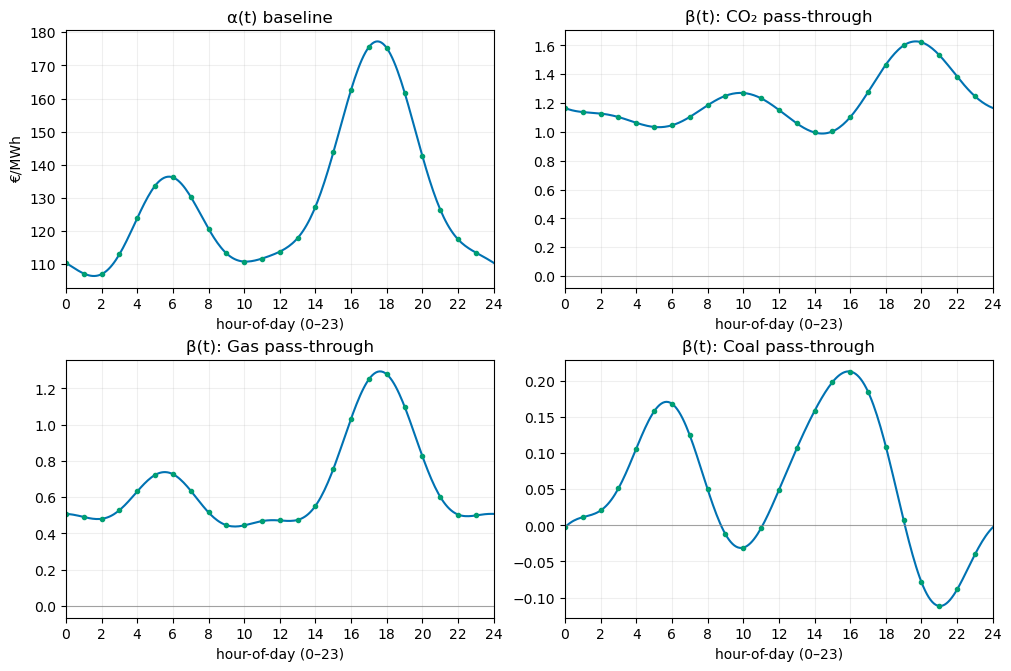

In [10]:
betas_hour, fig_hour, brief_hour = fit_concurrent_calendar(
    df, TS_COL, Y_COL, X_COLS,
    calendar="hour", n_basis=9, labels=LABELS,
    save_prefix="skfda"
)
fig_hour; brief_hour; betas_hour

### Fit week domain

Saved: skfda_week_betas.csv
Saved: skfda_week_betas.png


,t,alpha,beta_CO₂,beta_Gas,beta_Coal
0,0,117.715671,2.843576,0.777047,0.092569
1,1,121.566379,2.548862,0.912558,0.103683
2,2,128.708484,0.713024,1.182706,0.095181
3,3,136.229851,-2.766188,1.428905,0.144280
4,4,141.264124,-7.675194,1.453566,0.322462
5,5,142.061319,-13.431377,1.107744,0.661101
6,6,138.585555,-19.148129,0.372391,1.133600
7,7,132.415157,-23.832253,-0.606340,1.663093
8,8,126.007112,-26.664307,-1.550898,2.151711
9,9,121.647265,-27.260944,-2.148989,2.516388


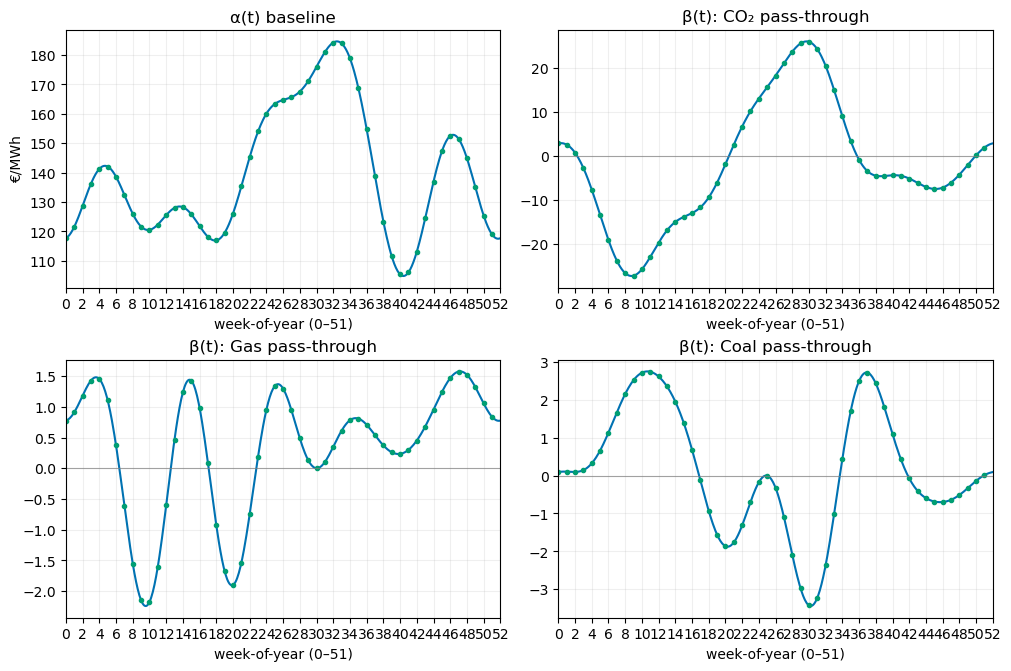

In [11]:
betas_week, fig_week, brief_week = fit_concurrent_calendar(
    df, TS_COL, Y_COL, X_COLS,
    calendar="week", n_basis=13, labels=LABELS,
    save_prefix="skfda"
)
fig_week; brief_week; betas_week

### Fit month domain

Saved: skfda_month_betas.csv
Saved: skfda_month_betas.png


,t,alpha,beta_CO₂,beta_Gas,beta_Coal
0,0,133.343785,-4.131113,7.410838,3.022962
1,1,128.862293,-34.861547,5.400568,4.169029
2,2,129.175858,-92.334449,-0.669113,12.687433
3,3,124.973336,-162.763669,-0.326150,13.396739
4,4,123.799030,-193.425652,6.530285,8.261478
5,5,146.001369,-135.342078,8.448174,7.996282
6,6,177.904431,-14.349265,2.865275,4.995909
7,7,178.810809,80.800824,-0.194105,-11.235763
8,8,145.397816,95.736871,2.907292,-25.112875
9,9,120.076024,59.209584,4.665695,-16.095284


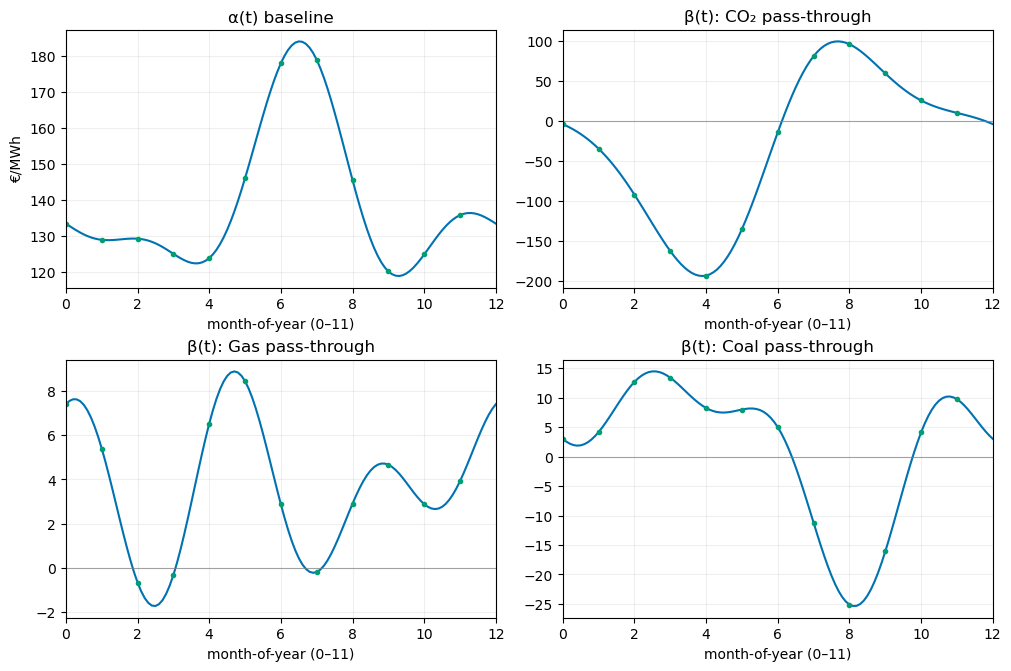

In [12]:
betas_month, fig_month, brief_month = fit_concurrent_calendar(
    df, TS_COL, Y_COL, X_COLS,
    calendar="month", n_basis=7, labels=LABELS,
    save_prefix="skfda"
)
fig_month; brief_month; betas_month

### Fit quarter domain

Saved: skfda_quarter_betas.csv
Saved: skfda_quarter_betas.png


,t,alpha,beta_CO₂,beta_Gas,beta_Coal
0,0,132.172583,9.182868,5.151539,1.943443
1,1,132.593686,-18.904373,-0.529503,-0.039092
2,2,166.436341,83.443162,2.273217,-2.335064
3,3,125.317174,28.730273,0.861808,1.756921


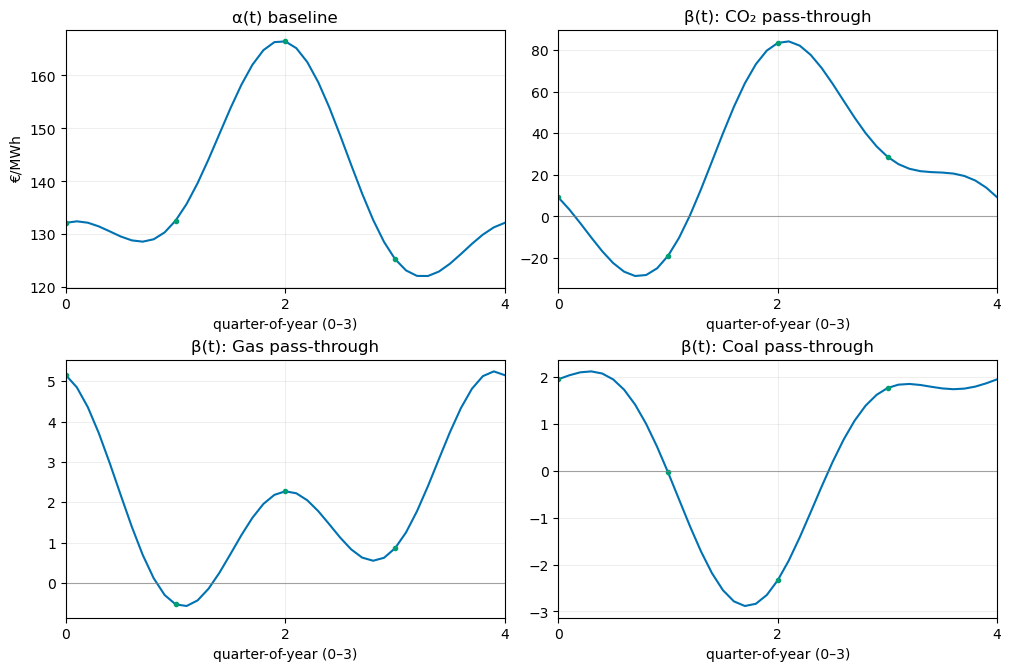

In [13]:
betas_quarter, fig_quarter, brief_quarter = fit_concurrent_calendar(
    df, TS_COL, Y_COL, X_COLS,
    calendar="quarter", n_basis=5, labels=LABELS,
    save_prefix="skfda"
)
fig_quarter; brief_quarter; betas_quarter

### Visual Exploration (monthly)

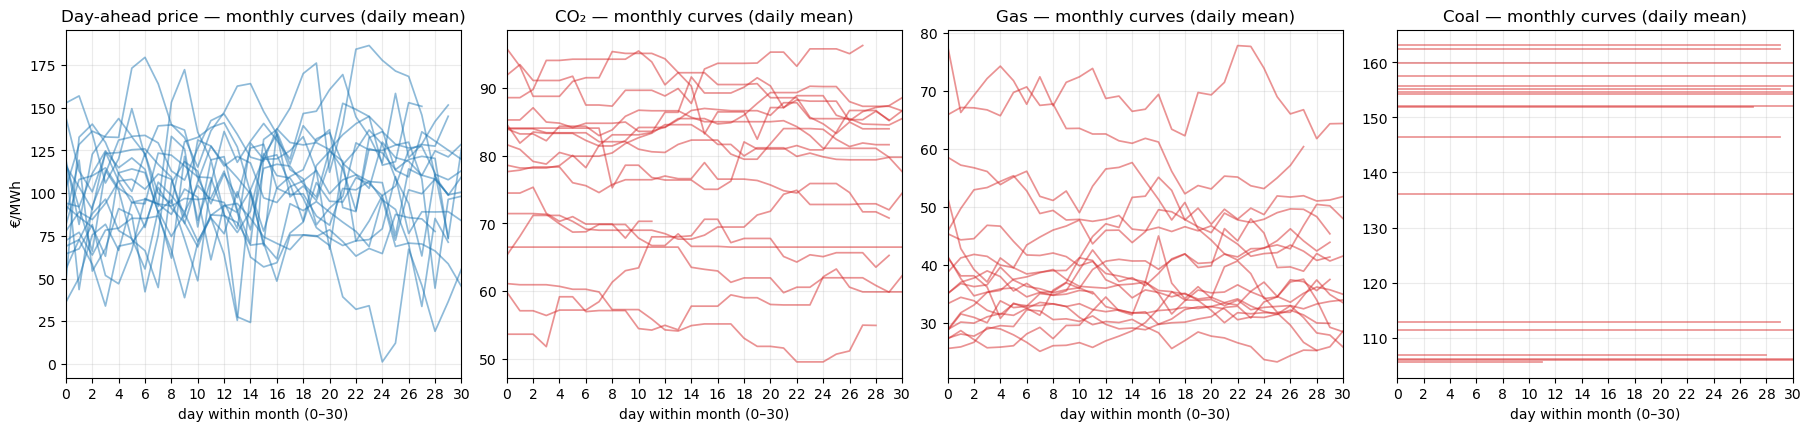

In [14]:
fig = plot_monthly_curves_fourpanel(
    df,
    ts_col="datetime",
    y_col="day_ahead_price_eur",
    x_cols=["co2_eur/ton", "natural_gas_eur/mwh", "coal_eur/ton"],
    labels=["Day-ahead price", "CO₂", "Gas", "Coal"],
    start="2023-01-01",
    end="2025-01-01",
    alpha=0.50, lw=1.25,
    agg="mean"
)